In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from io import StringIO
from glob import glob
import wandb
%matplotlib inline

In [4]:
their_data = """1 | 0.512 (0.434,0.593) | 1.18 (1.137,1.220)
2 | 0.604(0.589,0.620) |1.10(1.044,1.153)
3 | 0.624(0.617,0.632)|1.06(1.015,1.103)
4 | 0.602(0.520,0.684)|1.045(0.988,1.101)
5 | 0.623(0.614,0.636)|1.03(0.960,1.107)
6 | 0.636(0.628,0.647)|1.042(0.937,1.147)"""
their_data = their_data.replace(' ','').replace('|',',').replace('(',',').replace(')',',').replace(',,',',')
their_df = pd.read_csv(StringIO(their_data),sep=',',header=None)
their_df.columns = ['Addnl Ligs','R','R_stdl','R_stdg','RMSE','RMSE_stdl','RMSE_stdg','bad']
del their_df['bad']

In [5]:
their_df['R_std'] = (their_df['R']-their_df['R_stdl'])+(their_df['R_stdg']-their_df['R'])/2
their_df['RMSE_std'] = (their_df['RMSE']-their_df['RMSE_stdl'])+(their_df['RMSE_stdg']-their_df['RMSE'])/2

In [6]:
their_df

,Addnl Ligs,R,R_stdl,R_stdg,RMSE,RMSE_stdl,RMSE_stdg,R_std,RMSE_std
0,1,0.512,0.434,0.593,1.180,1.137,1.220,0.1185,0.0630
1,2,0.604,0.589,0.620,1.100,1.044,1.153,0.0230,0.0825
2,3,0.624,0.617,0.632,1.060,1.015,1.103,0.0110,0.0665
3,4,0.602,0.520,0.684,1.045,0.988,1.101,0.1230,0.0850
4,5,0.623,0.614,0.636,1.030,0.960,1.107,0.0155,0.1085
5,6,0.636,0.628,0.647,1.042,0.937,1.147,0.0135,0.1575


In [7]:
# Pulling this data from W&B Report
my_data_list = [[1,0.5328,0.03314,1.134,0.0379],
               [2,0.6499,0.01873,0.9712,0.02487],
               [3,0.7026,0.01578,0.8981,0.02793],
               [4,0.734,0.01361,0.8504,0.02235],
               [5,0.758,0.01064,0.8127,0.01831],
               [6,0.7758,0.01302,0.7829,0.02375]]
my_df = pd.DataFrame(my_data_list,columns=['Addnl Ligs','R','R_std','RMSE','RMSE_std'])

In [8]:
my_df

,Addnl Ligs,R,R_std,RMSE,RMSE_std
0,1,0.5328,0.03314,1.1340,0.03790
1,2,0.6499,0.01873,0.9712,0.02487
2,3,0.7026,0.01578,0.8981,0.02793
3,4,0.7340,0.01361,0.8504,0.02235
4,5,0.7580,0.01064,0.8127,0.01831
5,6,0.7758,0.01302,0.7829,0.02375


In [9]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


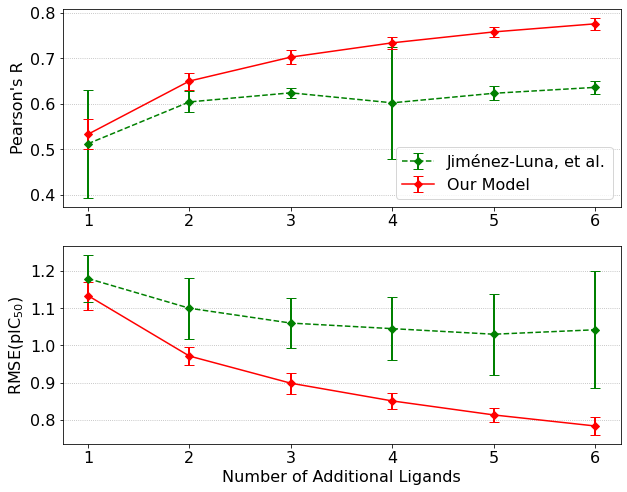

In [10]:
plt.figure(figsize=(10,8))
plt.subplot(211)
plt.errorbar(their_df['Addnl Ligs'],their_df['R'],yerr=their_df['R_std'],label='Jiménez-Luna, et al.',c='g',linestyle='--',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
plt.errorbar(my_df['Addnl Ligs'],my_df['R'],yerr=my_df['R_std'],label='Our Model',c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
plt.ylabel("Pearson's R")
plt.legend()
ax = plt.gca()
ax.grid(axis='y',linestyle=':')
plt.subplot(212)
plt.errorbar(their_df['Addnl Ligs'],their_df['RMSE'],yerr=their_df['RMSE_std'],label='Jiménez-Luna, et al.',c='g',linestyle='--',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
plt.errorbar(my_df['Addnl Ligs'],my_df['RMSE'],yerr=my_df['RMSE_std'],label='ours',c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
plt.xlabel('Number of Additional Ligands')
plt.ylabel("RMSE(pIC$_{50}$)")
ax = plt.gca()
ax.grid(axis='y',linestyle=':')
# plt.savefig('paper_comparison_both.png',dpi=500)

In [75]:
paper_values = dict()
for filename in glob('external_test/*/Paper_*_R*.csv'):
    testset = filename.split('/')[1]
    measure = filename.split('_')[-1].split('.')[0]
    raw = pd.read_csv(filename,header=None)
    raw.columns = ['x','y']
    raw = raw.round({'x':0,'y':3})
    sorted_groupby = raw.sort_values(by=['x','y']).groupby('x')
    final = sorted_groupby.nth(1)
    final['std'] = (sorted_groupby.nth(2)-sorted_groupby.nth(0))/2
    if testset not in paper_values:
        paper_values[testset] = dict()
    paper_values[testset][measure] = final
paper_values.keys()

dict_keys(['Thrombin', 'JNK1', 'BRD4'])

In [120]:
external_dataset_measures=['Thrombin.Test RMSE','Thrombin.Test R','P38.Test RMSE','P38.Test R','BACE.Test RMSE',
                           'BACE.Test R','JNK1.Test RMSE','JNK1.Test R','PTP1B.Test RMSE','PTP1B.Test R',
                           'CDK2.Test RMSE','CDK2.Test R','BRD4.Test RMSE','BRD4.Test R','MCL1.Test RMSE',
                           'MCL1.Test R','TYK2.Test RMSE','TYK2.Test R']
pub_api = wandb.apis.public.Api()
runs = pub_api.runs(path='andmcnutt/DDG_model_Regression',
             filters={"$and":[{"config.use_model":'multtask_latent_def2018'},{'config.trainfile':'all_newdata.types'},
                             {"config.dropout":int(0)},{"config.stratify_rec":False},{"config.eval":True},{"state":"finished"}]})
our_data = pd.DataFrame(columns=external_dataset_measures)
for run in runs:
    new_row = pd.DataFrame.from_dict(run.history(keys=external_dataset_measures,pandas=False)[0][0],orient='index').T
    our_data = our_data.append(new_row,ignore_index=True)

In [140]:
final_data = pd.concat([our_data.mean(axis=0),our_data.std(axis=0)],axis=1)
final_data.columns = ['mean','std']

In [141]:
final_data

,mean,std
Thrombin.Test RMSE,0.656247,0.193668
Thrombin.Test R,0.383505,0.396609
P38.Test RMSE,1.079460,0.114773
P38.Test R,0.376796,0.158208
BACE.Test RMSE,1.108909,0.175508
BACE.Test R,0.293784,0.301428
JNK1.Test RMSE,0.924049,0.205106
JNK1.Test R,0.370632,0.325362
PTP1B.Test RMSE,1.045465,0.267133
PTP1B.Test R,0.664281,0.216829


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


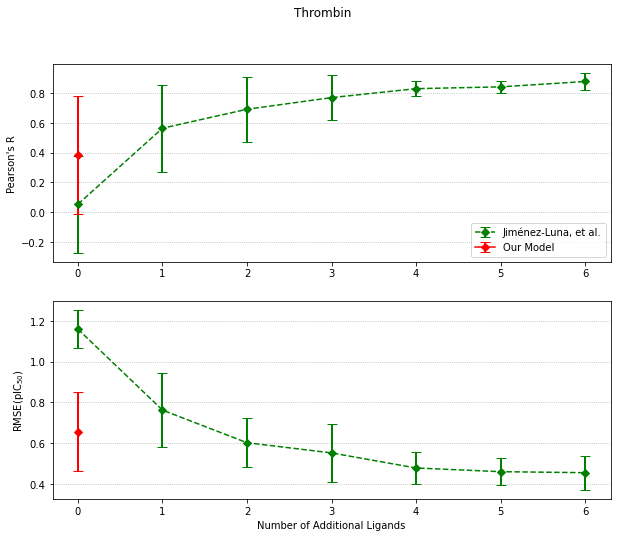

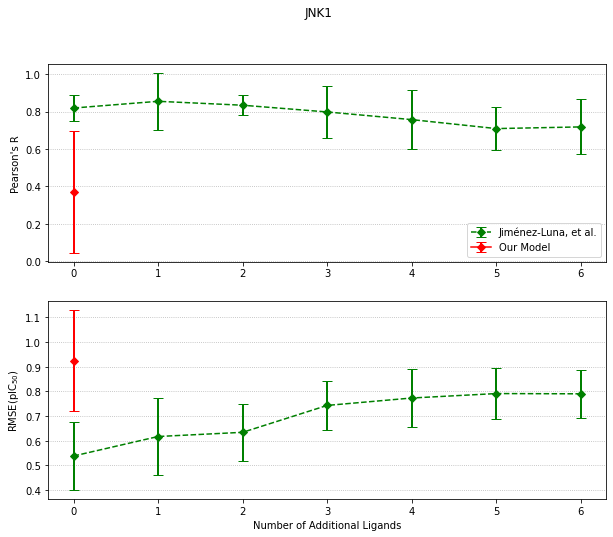

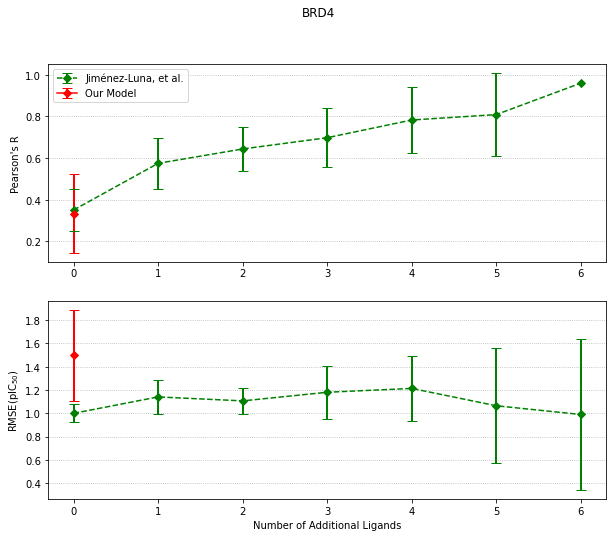

In [150]:
for test_set in paper_values.keys():
    plt.figure(figsize=(10,8))
    plt.suptitle(test_set)
    plt.subplot(211)
    plt.errorbar(paper_values[test_set]['R'].index,paper_values[test_set]['R']['y'],yerr=paper_values[test_set]['R']['std'],label='Jiménez-Luna, et al.',c='g',linestyle='--',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
    plt.errorbar(0,final_data.loc[f'{test_set}.Test R','mean'],yerr=final_data.loc[f'{test_set}.Test R','std'],label='Our Model',c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
    plt.ylabel("Pearson's R")
    plt.legend()
    ax = plt.gca()
    ax.grid(axis='y',linestyle=':')
    plt.subplot(212)
    plt.errorbar(paper_values[test_set]['RMSE'].index,paper_values[test_set]['RMSE']['y'],yerr=paper_values[test_set]['RMSE']['std'],label='Jiménez-Luna, et al.',c='g',linestyle='--',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
    plt.errorbar(0,final_data.loc[f'{test_set}.Test RMSE','mean'],yerr=final_data.loc[f'{test_set}.Test RMSE','std'],label='ours',c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
    plt.xlabel('Number of Additional Ligands')
    plt.ylabel("RMSE(pIC$_{50}$)")
    ax = plt.gca()
    ax.grid(axis='y',linestyle=':')
